### Assignment 6: Jump Predition

**Name: Shiqi Hu**
**GTID: 904061372**

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import skew, kurtosis
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from scipy import stats
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')

In [143]:
from torchviz import make_dot, make_dot_from_trace

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from itertools import product

#### Data Construction and Analysis
---

#### 0. Data Import and Sample Firm Selection

In [144]:
full_data = pd.read_csv(r"C:\Users\siki_\OneDrive - Georgia Institute of Technology\Gatech QCF\Yr1 Sem1\MGT 8803\A6\MSF_1996_2023.csv")

full_data['date'] = pd.to_datetime(full_data['date'], format = '%Y-%m-%d')
full_data['year'] = full_data['date'].dt.year
full_data['month'] = pd.to_datetime(full_data['date']).dt.to_period('M')
full_data['SICCD'] = pd.to_numeric(full_data['SICCD'], errors='coerce')
full_data['RET'] = pd.to_numeric(full_data['RET'], errors='coerce')
full_data['vwretd'] = pd.to_numeric(full_data['vwretd'], errors='coerce')
full_data['MarketCap'] = full_data['PRC'] * full_data['SHROUT']

In [145]:
def classify_industry(SICCD):
    if 1 <= SICCD <= 999:
        return 'Agriculture, Forestry and Fishing'
    elif 1000 <= SICCD <= 1499:
        return 'Mining'
    elif 1500 <= SICCD <= 1799:
        return 'Construction'
    elif 2000 <= SICCD <= 3999:
        return 'Manufacturing'
    elif 4000 <= SICCD <= 4999:
        return 'Transportation and other Utilities'
    elif 5000 <= SICCD <= 5199:
        return 'Wholesale Trade'
    elif 5200 <= SICCD <= 5999:
        return 'Retail Trade'
    elif 6000 <= SICCD <= 6799:
        return 'Finance, Insurance and Real Estate'
    elif 7000 <= SICCD <= 8999:
        return 'Services'
    elif 9000 <= SICCD <= 9999:
        return 'Public Administration'
    else:
        return 'Unknown'

full_data['industry'] = full_data['SICCD'].apply(classify_industry)

full_data = full_data[full_data['industry'] != 'Unknown']

In [146]:
risk_free_df = pd.read_csv(r"C:\Users\siki_\OneDrive - Georgia Institute of Technology\Gatech QCF\Yr1 Sem1\MGT 8803\A6\Risk free data_U.S. 10 Year Treasury Note.csv")

risk_free_df['Date'] = pd.to_datetime(risk_free_df['Date'])
risk_free_df['rf_rate'] = risk_free_df['Close'].str.rstrip('%').astype('float') / 100
risk_free_df = risk_free_df[['Date', 'rf_rate']]

full_data = pd.merge(full_data, risk_free_df, left_on='date', right_on='Date', how='left')

full_data = full_data.drop('Date', axis=1)

full_data['rf_rate'] = full_data['rf_rate'].fillna(method='bfill')

full_data['excess_ret'] = full_data['RET'] - full_data['rf_rate']
full_data['excess_mkt_ret'] = full_data['vwretd'] - full_data['rf_rate']

In [147]:
full_data_clean = full_data[['date','year','month','PERMCO','PRC','VOL','excess_ret','excess_mkt_ret','MarketCap','industry','rf_rate','RET','vwretd','SHROUT']]
full_data_clean = full_data_clean.dropna(subset=['PRC', 'RET','MarketCap', 'SHROUT'])
# full_data_clean

#### Step 1: Construct a categorical outcome variable
---

In [148]:
full_data_clean['abs_ret'] = full_data_clean['RET'].abs()
full_data_clean['ret_jump'] = full_data_clean['abs_ret'].apply(lambda x: 1 if x > 0.1 else 0)
# full_data_clean


#### Step 2: Plot the percentage of jumps over time along with the three macro-economic indicators from FRED
---

In [149]:
import pandas_datareader as pdr
from datetime import datetime

# Define the start and end dates
start_date = datetime(1996, 1, 1)
end_date = datetime(2023, 12, 31)

# Fetch FRED data using pandas_datareader
unemploy_rate = pdr.get_data_fred('UNRATE', start=start_date, end=end_date)
cpi = pdr.get_data_fred('CPIAUCSL', start=start_date, end=end_date)
fed_funds_rate = pdr.get_data_fred('FEDFUNDS', start=start_date, end=end_date)
vix = pdr.get_data_fred('VIXCLS', start=start_date, end=end_date)

# Reset index for better handling
unemploy_rate.reset_index(inplace=True)
cpi.reset_index(inplace=True)
fed_funds_rate.reset_index(inplace=True)
vix.reset_index(inplace=True)

# Rename columns for clarity
unemploy_rate.columns = ['Date', 'unemploy_rate']
cpi.columns = ['Date', 'cpi']
fed_funds_rate.columns = ['Date', 'fed_funds_rate']
vix.columns = ['Date', 'vix']

# Create Month column
unemploy_rate['Month'] = pd.to_datetime(unemploy_rate['Date']).dt.to_period('M')
cpi['Month'] = pd.to_datetime(cpi['Date']).dt.to_period('M')
fed_funds_rate['Month'] = pd.to_datetime(fed_funds_rate['Date']).dt.to_period('M')

vix['Month'] = pd.to_datetime(vix['Date']).dt.to_period('M')
vix_monthly = vix.groupby('Month')['vix'].mean().reset_index()

full_data_clean = pd.merge(full_data_clean, unemploy_rate, left_on='month', right_on='Month', how='left')
full_data_clean = full_data_clean.drop(['Month','Date'], axis=1)
full_data_clean = pd.merge(full_data_clean, cpi, left_on='month', right_on='Month', how='left')
full_data_clean = full_data_clean.drop(['Month','Date'], axis=1)
full_data_clean = pd.merge(full_data_clean, fed_funds_rate, left_on='month', right_on='Month', how='left')
full_data_clean = full_data_clean.drop(['Month','Date'], axis=1)
full_data_clean = pd.merge(full_data_clean, vix_monthly, left_on='month', right_on='Month', how='left')
full_data_clean = full_data_clean.drop(['Month'], axis=1)

# full_data_clean


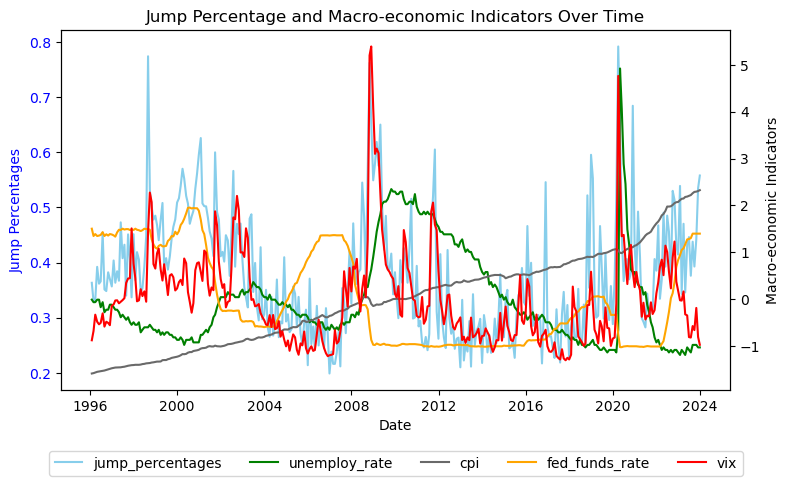

In [150]:
jump_percentages = full_data_clean.groupby('date')['ret_jump'].mean()

plot_data = pd.DataFrame({
    'jump_percentages': jump_percentages,
    'unemploy_rate': full_data_clean.groupby('date')['unemploy_rate'].first(),
    'cpi': full_data_clean.groupby('date')['cpi'].first(),
    'fed_funds_rate': full_data_clean.groupby('date')['fed_funds_rate'].first(),
    'vix': full_data_clean.groupby('date')['vix'].first()
})

# Reset index to make 'date' a column
plot_data = plot_data.reset_index()

# Create the plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot jump percentages
ax1.plot(plot_data['date'], plot_data['jump_percentages'], color='skyblue', label='jump_percentages')
ax1.set_xlabel('Date')
ax1.set_ylabel('Jump Percentages', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for macro-economic indicators
ax2 = ax1.twinx()

# Standardize macro-economic indicators
scaler = StandardScaler()
columns_to_scale = ['unemploy_rate', 'cpi', 'fed_funds_rate', 'vix']
plot_data[columns_to_scale] = scaler.fit_transform(plot_data[columns_to_scale])

# Plot macro-economic indicators
ax2.plot(plot_data['date'], plot_data['unemploy_rate'], color='green', label='unemploy_rate')
ax2.plot(plot_data['date'], plot_data['cpi'], color='dimgray', label='cpi')
ax2.plot(plot_data['date'], plot_data['fed_funds_rate'], color='orange', label='fed_funds_rate')
ax2.plot(plot_data['date'], plot_data['vix'], color='red', label='vix')
ax2.set_ylabel('Macro-economic Indicators', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=5)

plt.title('Jump Percentage and Macro-economic Indicators Over Time')
plt.tight_layout()
plt.show()

In [151]:
# correlation_matrix = plot_data[['jump_percentages', 'unemploy_rate', 'cpi', 'fed_funds_rate', 'vix']].corr()
# correlation_matrix
# # Plotting the heatmap
# plt.figure(figsize=(10, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
# plt.title("Correlation Heatmap of Jump Percentages and Macro-economic Indicators")
# plt.show()

**What do you observe?- Can any of these indicators serve as a precursor for upcoming higher likelihood of jumps?**

**Time series observations:**
- The jump percentages appear highly volatile, with frequent spikes.

- There are noticeable spikes around 2008 (financial crisis) and 2020 (COVID-19 pandemic), where jump percentages, VIX, and unemployment rate all show significant increases.

**Relationship with macro indicators:**
- Jump percentages has very strong positive correlation (0.72) with VIX, indicating that periods of high market volatility are strongly associated with a higher likelihood of jump events.

- However, in comparison, jump percentages has weak to moderate correlations with other indicators. 
  - Fed funds rate shows a weak positive correlation (0.24) with jump percentages.
  - CPI (Consumer Price Index) has a weak negative correlation (-0.13) with jump percentages.
  - Unemployment rate has a very weak negative correlation (-0.042) with jump percentages.

**Precursors analysis**
- while all these indicators provide some insight, the VIX stands out as the most promising precursor for upcoming higher likelihood of jumps. However, a holistic approach considering multiple indicators, especially during periods of economic stress or uncertainty, would likely provide the most robust predictive power for jump events.

#### Step 3: Come up with a list of possible covariates that should matter for jump prediction.
---
 
**List of possible covariates:**
- Predicted neural beta
- Industry (dummy)
- Lagging 12 month price, return, market return, month volume, market capitalization, annualized volatility, USREC, VIX, unemployment rate, cpi, and fed fund rate.


In [152]:
# Add USREC data
NBER_df = pd.read_csv(r"C:\Users\siki_\OneDrive - Georgia Institute of Technology\Gatech QCF\Yr1 Sem1\MGT 8803\A6\USREC_NBER.csv")
NBER_df['DATE'] = pd.to_datetime(NBER_df['DATE']).dt.to_period('M')
NBER_df = NBER_df[(NBER_df['DATE'] >= '1996-01') & (NBER_df['DATE'] <= '2023-12')]

full_data_clean = pd.merge(full_data_clean, NBER_df, left_on='month', right_on='DATE', how='left')
full_data_clean = full_data_clean.drop('DATE', axis=1)
# full_data_clean

In [153]:
# Add volatility
daily_volatility = full_data_clean.groupby('PERMCO')['RET'].std()
annualized_volatility = daily_volatility * np.sqrt(252)
annualized_volatility = annualized_volatility.reset_index()
annualized_volatility.columns = ['PERMCO', "annualized_volatility"]

full_data_clean = pd.merge(full_data_clean, annualized_volatility, on='PERMCO', how='inner')
full_data_clean = full_data_clean.dropna()

Sample 10 company each industry each year, and get the whole year data for the company selected in that year.


In [154]:
def sample_unique_companies(group):

    unique_companies = group.drop_duplicates(subset='PERMCO')
    
    return unique_companies.sample(n=min(len(unique_companies), 10), replace=False)

sample_comp = full_data_clean.groupby(['year', 'industry']).apply(sample_unique_companies).reset_index(drop=True)

sample_data = pd.DataFrame()

for _, row in sample_comp.iterrows():
    matching_data = full_data_clean[(full_data_clean['year'] == row['year']) & (full_data_clean['PERMCO'] == row['PERMCO'])]
    sample_data = pd.concat([sample_data, matching_data], ignore_index=True)

# print(f"This is the shape of my sample_data {sample_data.shape}")
# print('My sample data is: ')

# sample_data


In [155]:
def trailing_df(df, months):

    df['start_date'] = df['date'] - pd.DateOffset(months=months)

    trailing_data = full_data_clean[(full_data_clean['PERMCO'].isin(df['PERMCO'])) &
                                    (full_data_clean['date'] >= df['start_date'].min()) &
                                    (full_data_clean['date'] <= df['date'].max())].copy()
    
    trailing_data = pd.merge(trailing_data, df[['PERMCO', 'date', 'start_date']], 
                             on=['PERMCO'], how='left', suffixes=('', '_end'))
    
    trailing_data = trailing_data[(trailing_data['date'] >= trailing_data['start_date']) & 
                                  (trailing_data['date'] <= trailing_data['date_end'])]

    trailing_data[f'start_date_of_trailing_{months}M'] = trailing_data['start_date']

    trailing_data[f'end_date_of_trailing_{months}M'] = trailing_data['date_end']

    trailing_data = trailing_data.drop(columns=['start_date', 'date_end'])
    
    return trailing_data.sort_values([f'end_date_of_trailing_{months}M', 'PERMCO', 'date'])

sample_trailing_12M_df = trailing_df(sample_data, 12)
# sample_trailing_12M_df



In [156]:
def create_lagged_features(df, months, features):
    
    df = df.sort_values([f'end_date_of_trailing_{months}M', 'PERMCO', 'date'])
    
    for feature in features:
        for lag in range(1, months + 1):
            df[f'{feature}_lag_{lag}'] = df.groupby('PERMCO')[feature].shift(lag)

    df = df.groupby(['PERMCO', f'end_date_of_trailing_{months}M']).last().reset_index()
    df = df.sort_values('date').reset_index(drop=True)
    return df

features = ['RET', 'vwretd', 'PRC', 'VOL', 'MarketCap', 'annualized_volatility', 'USREC', 'vix', 'unemploy_rate', 'cpi', 'fed_funds_rate']

sample_12M_lagged = create_lagged_features(sample_trailing_12M_df, 12, features)
sample_12M_lagged = sample_12M_lagged.dropna()
sample_12M_lagged = sample_12M_lagged.reset_index(drop=True)

# display(sample_12M_lagged.columns)
# display(sample_12M_lagged)

In [157]:
# Prepare for test set for using neural beta model
def prepare_nn_features(df, months, features, scaler=None):
    feature_columns = []

    for feature in features:
        for lag in range(1, months + 1):
            feature_columns.append(f'{feature}_lag_{lag}')

    industry_dummies = pd.get_dummies(df['industry'], prefix='industry')
    df = pd.concat([df, industry_dummies], axis=1)
    feature_columns.extend(industry_dummies.columns)

    X = df[feature_columns]

    for feature in features:
        feature_mean = X[[f'{feature}_lag_{lag}' for lag in range(1, months + 1)]].mean().mean()
        for lag in range(1, months + 1):
            X[f'{feature}_lag_{lag}'].fillna(feature_mean, inplace=True)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    y = df[['RET', 'vwretd']].values
    
    return X_scaled, y, scaler, feature_columns

features_for_beta = ['RET', 'vwretd', 'PRC', 'VOL','MarketCap']
X_test_12M, y_test_12M, _, _ = prepare_nn_features(sample_12M_lagged, 12, features_for_beta)

In [158]:
# print(f"X_test_12M shape: {X_test_12M.shape}")


In [159]:
# Neural beta calculation for sample data
class NeuralBeta(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralBeta, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)    
        self.activation = nn.Sigmoid()     
        self.output = nn.Linear(hidden_size, 1)  
    
    def forward(self, x):
        x = self.activation(self.hidden(x))
        return self.output(x)

input_size = X_test_12M.shape[1]
hidden_size = 128

final_model = NeuralBeta(input_size, hidden_size)

final_model.load_state_dict(torch.load(r"C:\Users\siki_\OneDrive - Georgia Institute of Technology\Gatech QCF\Yr1 Sem1\MGT 8803\A5\beta_prediction_model.pth"))

final_model.eval()

X_test = torch.FloatTensor(X_test_12M)
y_test = torch.FloatTensor(y_test_12M)

final_model.eval()
with torch.no_grad():
    predicted_betas = final_model(X_test).squeeze().numpy()

sample_12M_lagged['predicted_beta'] = predicted_betas

# display(sample_12M_lagged)

In [160]:
inSample_df = sample_12M_lagged[(sample_12M_lagged['month'] >= '1996-01') & (sample_12M_lagged['month'] <= '2017-12')]
outSample_df = sample_12M_lagged[(sample_12M_lagged['month'] >= '2018-01') & (sample_12M_lagged['month'] <= '2023-12')]

In [161]:
def prepare_nn_features(df, months, features, scaler=None):
    feature_columns = []

    for feature in features:
        for lag in range(1, months + 1):
            feature_columns.append(f'{feature}_lag_{lag}')

    industry_dummies = pd.get_dummies(df['industry'], prefix='industry')
    df = pd.concat([df, industry_dummies], axis=1)
    feature_columns.extend(industry_dummies.columns)
    
    feature_columns.append('predicted_beta')
    
    X = df[feature_columns]
  
    for feature in features:
        feature_mean = X[[f'{feature}_lag_{lag}' for lag in range(1, months + 1)]].mean().mean()
        for lag in range(1, months + 1):
            X[f'{feature}_lag_{lag}'].fillna(feature_mean, inplace=True)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    y = df['ret_jump'].values
    
    return X_scaled, y, scaler, feature_columns

features = ['PRC', 'RET', 'VOL', 'vwretd', 'MarketCap', 'annualized_volatility', 'USREC', 'vix', 'unemploy_rate','cpi','fed_funds_rate']

X_train_12M, y_train_12M, scaler_12M, feature_columns_12M = prepare_nn_features(inSample_df, 12, features)
X_test_12M, y_test_12M, _, _  = prepare_nn_features(outSample_df, 12, features)

In [162]:
# X_train_12M

**Using 2018–2023 as the out of sample period**

Full Out-of-Sample - AUC: 0.6875
Full Out-of-Sample - KS Statistic: 0.2958


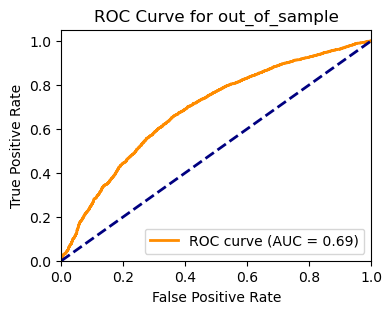

In [163]:
model = LogisticRegression(random_state=42)
model.fit(X_train_12M, y_train_12M)

y_pred_proba = model.predict_proba(X_test_12M)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_12M, y_pred_proba)
roc_auc = auc(fpr, tpr)
ks_statistic = np.max(np.abs(fpr - tpr))


print(f"Full Out-of-Sample - AUC: {roc_auc:.4f}")
print(f"Full Out-of-Sample - KS Statistic: {ks_statistic:.4f}")

plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for out_of_sample')
plt.legend(loc="lower right")
plt.show()

**Doing a rolling out of sample estimation**

Rolling Forecast - AUC: 0.6875
Rolling Forecast - KS Statistic: 0.2958


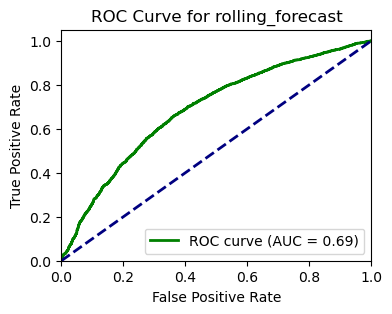

In [164]:
def rolling_forecast_monthly(X_train, y_train, X_test, y_test, inSample_df, outSample_df):
    all_predictions = []
    all_true_values = []
    
    for year in range(2018, 2024):
        for month in range(1, 13):
            current_date = pd.Period(year=year, month=month, freq='M')

            train_mask = inSample_df['month'] < current_date
            X_train_current = X_train[train_mask]
            y_train_current = y_train[train_mask]
            
            test_mask = (outSample_df['month'].dt.year == year) & (outSample_df['month'].dt.month == month)
            X_test_current = X_test[test_mask]
            y_test_current = y_test[test_mask]
          
            model = LogisticRegression(random_state=42)
            model.fit(X_train_current, y_train_current)
            y_pred_proba = model.predict_proba(X_test_current)[:, 1]
            
            all_predictions.extend(y_pred_proba)
            all_true_values.extend(y_test_current)
    
    return np.array(all_predictions), np.array(all_true_values)

y_pred_proba_rolling, y_test_rolling = rolling_forecast_monthly(X_train_12M, y_train_12M, X_test_12M, y_test_12M, inSample_df, outSample_df)

fpr_rolling, tpr_rolling, _ = roc_curve(y_test_rolling, y_pred_proba_rolling)
roc_auc_rolling = auc(fpr_rolling, tpr_rolling)

ks_statistic_rolling = np.max(np.abs(fpr_rolling - tpr_rolling))


print(f"Rolling Forecast - AUC: {roc_auc_rolling:.4f}")
print(f"Rolling Forecast - KS Statistic: {ks_statistic_rolling:.4f}")

plt.figure(figsize=(4,3))
plt.plot(fpr_rolling, tpr_rolling, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for rolling_forecast')
plt.legend(loc="lower right")
plt.show()



**Using a fixed window**

Fixed Window Forecast - AUC: 0.6204
Fixed Window Forecast - KS Statistic: 0.1967


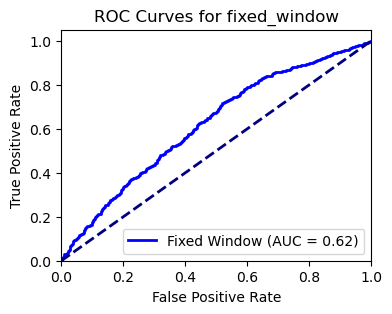

In [165]:
def fixed_window_forecast_monthly(X_train, y_train, X_test, y_test, inSample_df, outSample_df, window_size=24):  # 24 months = 2 years
    all_predictions = []
    all_true_values = []
    
    for year in range(2018, 2024):
        for month in range(1, 13):
            current_date = pd.Period(year=year, month=month, freq='M')
            window_start = current_date - window_size
          
            train_mask = (inSample_df['month'] >= window_start) & (inSample_df['month'] < current_date)
            X_train_current = X_train[train_mask]
            y_train_current = y_train[train_mask]
            
            test_mask = (outSample_df['month'].dt.year == year) & (outSample_df['month'].dt.month == month)
            X_test_current = X_test[test_mask]
            y_test_current = y_test[test_mask]
            
            if len(X_test_current) == 0 or len(X_train_current) == 0:
                continue  

            model = LogisticRegression(random_state=42)
            model.fit(X_train_current, y_train_current)
            y_pred_proba = model.predict_proba(X_test_current)[:, 1]
            
            all_predictions.extend(y_pred_proba)
            all_true_values.extend(y_test_current)
    
    return np.array(all_predictions), np.array(all_true_values)

y_pred_proba_fixed, y_test_fixed = fixed_window_forecast_monthly(X_train_12M, y_train_12M, X_test_12M, y_test_12M, inSample_df, outSample_df)

fpr_fixed, tpr_fixed, _ = roc_curve(y_test_fixed, y_pred_proba_fixed)
roc_auc_fixed = auc(fpr_fixed, tpr_fixed)

ks_statistic_fixed = np.max(np.abs(fpr_fixed - tpr_fixed))

print(f"Fixed Window Forecast - AUC: {roc_auc_fixed:.4f}")
print(f"Fixed Window Forecast - KS Statistic: {ks_statistic_fixed:.4f}")

plt.figure(figsize=(4,3))
plt.plot(fpr_fixed, tpr_fixed, color='blue', lw=2, label=f'Fixed Window (AUC = {roc_auc_fixed:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for fixed_window')
plt.legend(loc="lower right")
plt.show()

**Contrast the results:**
- The Full Out-of-Sample and Rolling Forecast methods show identical performance, with both having an AUC of 0.6875 and KS statistic of 0.2958. This suggests these approaches yield very similar predictive power.
- The Fixed Window Forecast method performs noticeably worse, suggesting it has significantly lower ability to discriminate between classes compared to using the full sample or rolling forecast approach.
- Therefore, from now on, I choose to use the full out-of-sample method as it has the best performance.

#### Model 2: LASSO Logistic regression 
---

Best λ for LASSO: 0.002486421189550464

Selected features by LASSO:
['PRC_lag_1' 'RET_lag_2' 'RET_lag_3' 'RET_lag_4' 'RET_lag_6' 'RET_lag_7'
 'RET_lag_9' 'RET_lag_10' 'RET_lag_12' 'VOL_lag_3' 'VOL_lag_10'
 'vwretd_lag_1' 'vwretd_lag_3' 'vwretd_lag_4' 'vwretd_lag_5'
 'vwretd_lag_8' 'vwretd_lag_11' 'vwretd_lag_12' 'MarketCap_lag_1'
 'MarketCap_lag_2' 'annualized_volatility_lag_1'
 'annualized_volatility_lag_2' 'USREC_lag_1' 'USREC_lag_5' 'vix_lag_1'
 'vix_lag_7' 'vix_lag_9' 'vix_lag_12' 'unemploy_rate_lag_8'
 'unemploy_rate_lag_12' 'fed_funds_rate_lag_9'
 'industry_Agriculture, Forestry and Fishing' 'industry_Construction'
 'industry_Finance, Insurance and Real Estate' 'industry_Manufacturing'
 'industry_Mining' 'industry_Public Administration'
 'industry_Retail Trade' 'industry_Services' 'industry_Wholesale Trade'
 'predicted_beta']
Post LASSO - AUC: 0.6977
Post LASSO - KS Statistic: 0.3047


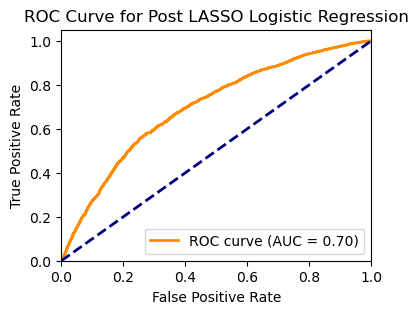

In [166]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_12M)
X_test_scaled = scaler.transform(X_test_12M)

lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train_12M)

best_alpha = lasso_cv.alpha_
print(f"Best λ for LASSO: {best_alpha}")

selected_features = np.abs(lasso_cv.coef_) > 0
selected_feature_names = np.array(feature_columns_12M)[selected_features]
print("\nSelected features by LASSO:")
print(selected_feature_names)

X_train_selected = X_train_scaled[:, selected_features]
X_test_selected = X_test_scaled[:, selected_features]

post_lasso_model = LogisticRegression(random_state=42)
post_lasso_model.fit(X_train_selected, y_train_12M)

y_pred_proba = post_lasso_model.predict_proba(X_test_selected)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_12M, y_pred_proba)
roc_auc = auc(fpr, tpr)
ks_statistic = np.max(np.abs(fpr - tpr))

print(f"Post LASSO - AUC: {roc_auc:.4f}")
print(f"Post LASSO - KS Statistic: {ks_statistic:.4f}")

plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Post LASSO Logistic Regression')
plt.legend(loc="lower right")
plt.show()


**Compare model performance of the Post LASSO Logistic regression model with the Logistic regression model built in Model-1. Does it perform better?**
- The Post LASSO model shows a slight improvement in AUC, indicating a marginal enhancement in the model's ability to distinguish between classes.
- Also, the KS statistic shows a small improvement. This suggests a slightly better separation between the positive and negative classes.
- The LASSO technique selected specific features, potentially reducing model complexity while maintaining or slightly improving performance. 

#### Model 3: Ridge Logistic regression
---

Best λ for Ridge: 10.0
Ridge - AUC: 0.6904
Ridge - KS Statistic: 0.3034


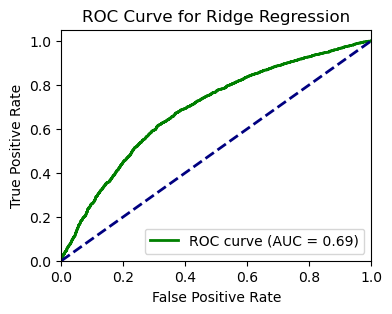

In [167]:
ridge_cv = RidgeCV(cv=5)
ridge_cv.fit(X_train_scaled, y_train_12M)

best_alpha_ridge = ridge_cv.alpha_
print(f"Best λ for Ridge: {best_alpha_ridge}")

ridge_model = LogisticRegression(penalty='l2', C=1/best_alpha_ridge, random_state=42)
ridge_model.fit(X_train_scaled, y_train_12M)

y_pred_proba_ridge = ridge_model.predict_proba(X_test_scaled)[:, 1]

fpr_ridge, tpr_ridge, _ = roc_curve(y_test_12M, y_pred_proba_ridge)
roc_auc_ridge = auc(fpr_ridge, tpr_ridge)
ks_statistic_ridge = np.max(np.abs(fpr_ridge - tpr_ridge))

print(f"Ridge - AUC: {roc_auc_ridge:.4f}")
print(f"Ridge - KS Statistic: {ks_statistic_ridge:.4f}")

plt.figure(figsize=(4,3))
plt.plot(fpr_ridge, tpr_ridge, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc_ridge:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ridge Regression')
plt.legend(loc="lower right")
plt.show()

**Compare model performance of the Ridge Regression model with the Logistic regression model built in Model-1.**
- The Ridge Regression model shows a slight improvement in AUC. This indicates a marginal enhancement in the model's discriminative ability.
- The KS statistic for the Ridge model is higher than that of the logistic model, suggesting the Ridge model achieves a slightly better separation between positive and negative classes.
- The Ridge Regression likely reduced overfitting compared to the standard logistic regression. A small but noticeable improvement in both AUC and KS statistic indicates better generalization to out-of-sample data.

#### Model- 4: K-Nearest Neighbor (KNN)
---

In [168]:
good_covariates = feature_columns_12M 
train_mask = (inSample_df['month'].dt.year < 2013)
val_mask = (inSample_df['month'].dt.year >= 2013) & (inSample_df['month'].dt.year <= 2017)

X_train = X_train_12M[train_mask]
y_train = y_train_12M[train_mask]
X_val = X_train_12M[val_mask]
y_val = y_train_12M[val_mask]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_12M)

param_grid = {'n_neighbors': range(1, 31)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Best K: {best_k}")

best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train)

y_val_pred = best_knn.predict(X_val_scaled)
val_misclassification_rate = 1 - accuracy_score(y_val, y_val_pred)
print(f"Validation Misclassification Rate: {val_misclassification_rate:.4f}")

y_test_pred_knn = best_knn.predict(X_test_scaled)
test_misclassification_rate_knn = 1 - accuracy_score(y_test_12M, y_test_pred_knn)
print(f"Test Misclassification Rate (KNN): {test_misclassification_rate_knn:.4f}")


Best K: 30
Validation Misclassification Rate: 0.2976
Test Misclassification Rate (KNN): 0.3697



Misclassification Rates:
Logistic Regression: 0.4323
LASSO Logistic Regression: 0.4323
Ridge Logistic Regression: 0.3947
K-Nearest Neighbors: 0.3697

The model with the lowest misclassification rate is: K-Nearest Neighbors


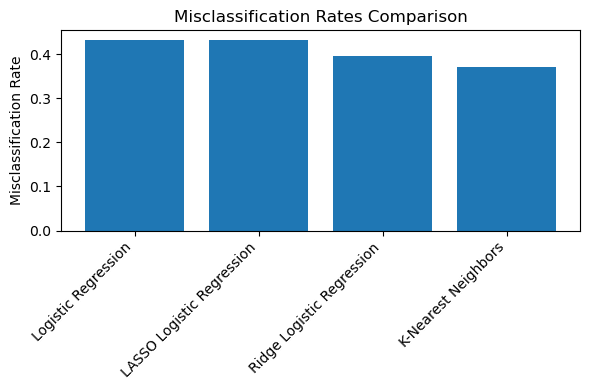

In [169]:
# Compare the misclassification rates of different models: Find the optimal threshold for the results of other models

def find_best_threshold(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    misclassification_rates = 1 - (tpr * (1 - y_true.mean()) + (1 - fpr) * y_true.mean())
    best_threshold = thresholds[np.argmin(misclassification_rates)]
    return best_threshold

best_threshold_logistic = find_best_threshold(y_test_12M, y_pred_proba)
y_pred_logistic = (y_pred_proba >= best_threshold_logistic).astype(int)
misclassification_rate_logistic = 1 - accuracy_score(y_test_12M, y_pred_logistic)

best_threshold_lasso = find_best_threshold(y_test_12M, y_pred_proba)
y_pred_lasso = (y_pred_proba >= best_threshold_lasso).astype(int)
misclassification_rate_lasso = 1 - accuracy_score(y_test_12M, y_pred_lasso)

best_threshold_ridge = find_best_threshold(y_test_12M, y_pred_proba_ridge)
y_pred_ridge = (y_pred_proba_ridge >= best_threshold_ridge).astype(int)
misclassification_rate_ridge = 1 - accuracy_score(y_test_12M, y_pred_ridge)

print("\nMisclassification Rates:")
print(f"Logistic Regression: {misclassification_rate_logistic:.4f}")
print(f"LASSO Logistic Regression: {misclassification_rate_lasso:.4f}")
print(f"Ridge Logistic Regression: {misclassification_rate_ridge:.4f}")
print(f"K-Nearest Neighbors: {test_misclassification_rate_knn:.4f}")

models = {
    "Logistic Regression": misclassification_rate_logistic,
    "LASSO Logistic Regression": misclassification_rate_lasso,
    "Ridge Logistic Regression": misclassification_rate_ridge,
    "K-Nearest Neighbors": test_misclassification_rate_knn
}

best_model = min(models, key=models.get)
print(f"\nThe model with the lowest misclassification rate is: {best_model}")

plt.figure(figsize=(6,4))
plt.bar(models.keys(), models.values())
plt.title("Misclassification Rates Comparison")
plt.ylabel("Misclassification Rate")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Which one has the lowest misclassification rate?**
- The K-Nearest Neighbors model has the lowest misclassification rate at 0.3697. This is significantly lower than the Logistic Regression and
LASSO Logistic Regression models, which all have misclassification rates above 0.43.
- Unlike the regression-based models, KNN adapts to local patterns in the feature space, which may be particularly effective for this dataset where linear decision boundaries are less optimal.

#### Models- 5: Pick ONE of the Gradient Boosted Tree Frameworks (XGBOOST)
---

In [170]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.3]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_xgb.fit(X_train_scaled, y_train)

y_val_pred = best_xgb.predict(X_val_scaled)
val_misclassification_rate = 1 - accuracy_score(y_val, y_val_pred)
print(f"Validation Misclassification Rate: {val_misclassification_rate:.4f}")

y_test_pred_xgb = best_xgb.predict(X_test_scaled)
test_misclassification_rate_xgb = 1 - accuracy_score(y_test_12M, y_test_pred_xgb)
print(f"Test Misclassification Rate (XGBoost): {test_misclassification_rate_xgb:.4f}")

feature_importance = best_xgb.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_columns_12M, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

print("Top 10 Feature Importances in XGBoost Model:")
print(feature_importance_df[['feature', 'importance']].head(10))

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Validation Misclassification Rate: 0.3000
Test Misclassification Rate (XGBoost): 0.3792
Top 10 Feature Importances in XGBoost Model:
                         feature  importance
60   annualized_volatility_lag_1    0.151995
0                      PRC_lag_1    0.074263
2                      PRC_lag_3    0.053053
12                     RET_lag_1    0.045344
1                      PRC_lag_2    0.042183
36                  vwretd_lag_1    0.039922
84                     vix_lag_1    0.036977
105         unemploy_rate_lag_10    0.035079
127         fed_funds_rate_lag_8    0.033806
93                    vix_lag_10    0.032936



Misclassification Rates:
Logistic Regression: 0.4323
LASSO Logistic Regression: 0.4323
Ridge Logistic Regression: 0.3947
K-Nearest Neighbors: 0.3697
XGBoost: 0.3792

The model with the lowest misclassification rate is: K-Nearest Neighbors


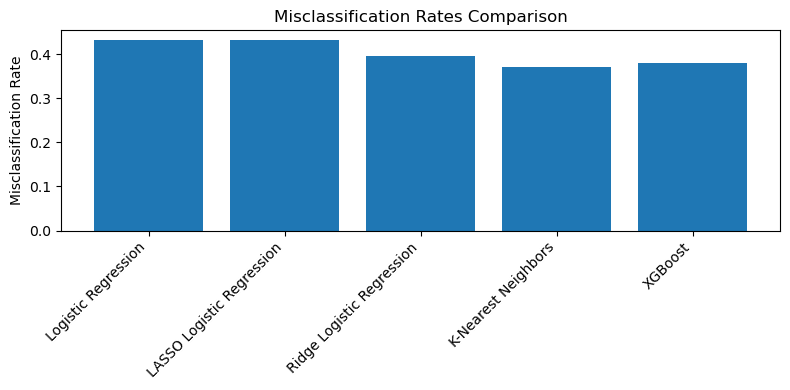

In [171]:
# Model comparison of misclassification rate
models = {
    "Logistic Regression": misclassification_rate_logistic,
    "LASSO Logistic Regression": misclassification_rate_lasso,
    "Ridge Logistic Regression": misclassification_rate_ridge,
    "K-Nearest Neighbors": test_misclassification_rate_knn,
    "XGBoost": test_misclassification_rate_xgb
}

print("\nMisclassification Rates:")
for model, rate in models.items():
    print(f"{model}: {rate:.4f}")

best_model = min(models, key=models.get)
print(f"\nThe model with the lowest misclassification rate is: {best_model}")

plt.figure(figsize=(8, 4))
plt.bar(models.keys(), models.values())
plt.title("Misclassification Rates Comparison")
plt.ylabel("Misclassification Rate")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

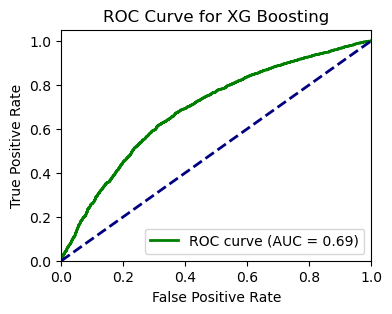

In [172]:
plt.figure(figsize=(4,3))
plt.plot(fpr_ridge, tpr_ridge, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc_ridge:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XG Boosting')
plt.legend(loc="lower right")
plt.show()

#### Compare misclassification rate of XGBoost algorithm with models built in earlier tasks. Which one has the lowest misclassification rate?
- The XGBoost algorithm has the misclassification rate at 0.3792, outperforming all other models except K-Nearest Neighbors. The KNN algorithm has the lowest misclassification rate at 0.3697, slightly outperforming XGBoost which has a rate of 0.3792.
- XGBoost performs better compare with most models because it's designed to learn complex patterns in data that simpler models might miss. It combines many decision trees and improves them step-by-step, allowing it to capture subtle relationships between features and make more accurate predictions.
- K-Nearest Neighbors likely performs best because it can capture complex local patterns without making strong assumptions about the overall data distribution. 

#### Model 6. ArtificialNeuralNetwork(ANN)for3-classclassification
---

In [173]:
def update_outcome(ret):
    if abs(ret) <= 0.1:
        return 0
    elif ret > 0.1:
        return 1
    else:
        return 2
    


inSample_df['new_ret_jump'] = inSample_df['RET'].apply(update_outcome)
outSample_df['new_ret_jump'] = outSample_df['RET'].apply(update_outcome)


def prepare_nn_features_for_new_jump(df, months, features, scaler=None):
    feature_columns = []

    for feature in features:
        for lag in range(1, months + 1):
            feature_columns.append(f'{feature}_lag_{lag}')

    industry_dummies = pd.get_dummies(df['industry'], prefix='industry')
    df = pd.concat([df, industry_dummies], axis=1)
    feature_columns.extend(industry_dummies.columns)
    
    feature_columns.append('predicted_beta')
 
    X = df[feature_columns]

    for feature in features:
        feature_mean = X[[f'{feature}_lag_{lag}' for lag in range(1, months + 1)]].mean().mean()
        for lag in range(1, months + 1):
            X[f'{feature}_lag_{lag}'].fillna(feature_mean, inplace=True)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
 
    y = df['new_ret_jump'].values
    
    return X_scaled, y, scaler, feature_columns

X_train_12M_new, y_train_12M_new, scaler_12M, feature_columns_12M = prepare_nn_features_for_new_jump(inSample_df, 12, features)
X_test_12M_new, y_test_12M_new, _, _  = prepare_nn_features(outSample_df, 12, features)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_12M_new)
X_test_scaled = scaler.transform(X_test_12M_new)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train_12M_new)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test_12M_new)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class JumpANN(nn.Module):
    def __init__(self, input_size):
        super(JumpANN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )
    
    def forward(self, x):
        return self.layers(x)

input_size = X_train_scaled.shape[1]
model = JumpANN(input_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    _, predicted = torch.max(y_pred, 1)

misclassification_rate_ann = 1 - accuracy_score(y_test_12M_new, predicted.numpy())
print(f"ANN Misclassification Rate: {misclassification_rate_ann:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_12M_new, predicted.numpy()))



Epoch [10/50], Loss: 0.9447
Epoch [20/50], Loss: 0.6757
Epoch [30/50], Loss: 0.6649
Epoch [40/50], Loss: 0.7337
Epoch [50/50], Loss: 0.7746
ANN Misclassification Rate: 0.4203

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.83      0.73      3966
           1       0.55      0.20      0.29      2553
           2       0.00      0.00      0.00         0

    accuracy                           0.58      6519
   macro avg       0.40      0.34      0.34      6519
weighted avg       0.61      0.58      0.56      6519




Misclassification Rates:
Logistic Regression: 0.4323
LASSO Logistic Regression: 0.4323
Ridge Logistic Regression: 0.3947
K-Nearest Neighbors: 0.3697
XGBoost: 0.3792
ANN: 0.4203


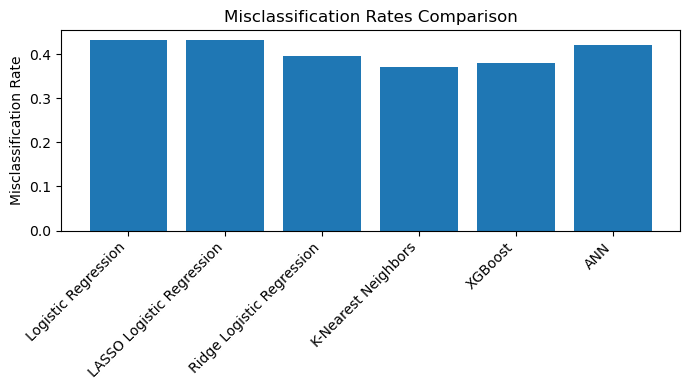

In [174]:
models = {
    "Logistic Regression": misclassification_rate_logistic,
    "LASSO Logistic Regression": misclassification_rate_lasso,
    "Ridge Logistic Regression": misclassification_rate_ridge,
    "K-Nearest Neighbors": test_misclassification_rate_knn,
    "XGBoost": test_misclassification_rate_xgb,
    "ANN": misclassification_rate_ann
}

print("\nMisclassification Rates:")
for model, rate in models.items():
    print(f"{model}: {rate:.4f}")

plt.figure(figsize=(7,4))
plt.bar(models.keys(), models.values())
plt.title("Misclassification Rates Comparison")
plt.ylabel("Misclassification Rate")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Compare the misclassification rate of MLP algorithm with models built in earlier tasks. Which one has the lowest misclassification rate?**
- ANN underperforms compared with Ridge Logistic Regression, K-Nearest Neighbors and XGBoost algorithm but outperforms compared with Logistic Regression and LASSO Logistic Regression in misclassification rate. 
- ANN's moderate performance suggests it captures some non-linear patterns better than basic logistic models, but may struggle with overfitting or optimal hyperparameter tuning compared to the top performers.
- The K-Nearest Neighbors model has the lowest at 0.3697, outperforming all other models including MLP. KNN performs the best is mainly because can capture complex local patterns without making strong assumptions about the overall data distribution.